In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

%matplotlib inline

In [2]:
file_path = Path("all_features.csv")
combined_df = pd.read_csv(file_path, infer_datetime_format = True, parse_dates = True, index_col = "date_time")
combined_df.sort_index(inplace=True)

In [3]:
combined_df

,close,vol,spy,return,Beta,WR,RSI,OBV,sentiment_vader,sentiment_rnn,us2y10y,vix,usdjpy
date_time,,,,,,,,,,,,,
2021-01-28 09:30:00,290.000,719438,376.500,-0.159420,-5.021900,-3.846154,24.616808,1063543.0,-1.0,-1.0,91.536,30.21,104.36
2021-01-28 09:31:00,300.160,48204,376.780,0.035034,-4.692537,-100.000000,29.976045,1111747.0,1.0,1.0,91.536,30.17,104.33
2021-01-28 09:32:00,300.160,48204,376.760,0.000000,-4.693024,-82.237762,30.142002,1159951.0,0.0,0.0,91.536,30.24,104.31
2021-01-28 09:33:00,300.160,48204,377.040,0.000000,-4.658830,-82.237762,30.632934,1208155.0,0.0,0.0,91.706,29.96,104.30
2021-01-28 09:34:00,300.160,48204,376.830,0.000000,-4.686281,-82.237762,31.696730,1256359.0,0.0,0.0,91.875,29.75,104.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-31 15:55:00,191.980,15778,396.345,-0.002447,2.943117,0.000000,70.208991,67647957.0,0.0,0.0,157.142,19.01,110.73
2021-03-31 15:56:00,191.960,13801,396.520,-0.000104,2.864469,-27.447552,63.737565,67634156.0,0.0,0.0,156.964,18.99,110.73
2021-03-31 15:57:00,191.951,21260,396.520,-0.000047,2.920564,-28.613054,60.113960,67612896.0,0.0,0.0,157.142,18.97,110.73


In [4]:
#combined_df['target_price'] = combined_df['close'].shift(-1)
combined_df['target_return'] = combined_df['return'].shift(-1)
combined_df = combined_df.dropna()

In [5]:
combined_df

,close,vol,spy,return,Beta,WR,RSI,OBV,sentiment_vader,sentiment_rnn,us2y10y,vix,usdjpy,target_return
date_time,,,,,,,,,,,,,,
2021-01-28 09:30:00,290.000,719438,376.500,-0.159420,-5.021900,-3.846154,24.616808,1063543.0,-1.0,-1.0,91.536,30.21,104.36,0.035034
2021-01-28 09:31:00,300.160,48204,376.780,0.035034,-4.692537,-100.000000,29.976045,1111747.0,1.0,1.0,91.536,30.17,104.33,0.000000
2021-01-28 09:32:00,300.160,48204,376.760,0.000000,-4.693024,-82.237762,30.142002,1159951.0,0.0,0.0,91.536,30.24,104.31,0.000000
2021-01-28 09:33:00,300.160,48204,377.040,0.000000,-4.658830,-82.237762,30.632934,1208155.0,0.0,0.0,91.706,29.96,104.30,0.000000
2021-01-28 09:34:00,300.160,48204,376.830,0.000000,-4.686281,-82.237762,31.696730,1256359.0,0.0,0.0,91.875,29.75,104.31,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-31 15:54:00,192.451,19272,396.600,0.001306,2.914251,-9.956367,72.658641,67663735.0,0.0,0.0,157.321,18.89,110.75,-0.002447
2021-03-31 15:55:00,191.980,15778,396.345,-0.002447,2.943117,0.000000,70.208991,67647957.0,0.0,0.0,157.142,19.01,110.73,-0.000104
2021-03-31 15:56:00,191.960,13801,396.520,-0.000104,2.864469,-27.447552,63.737565,67634156.0,0.0,0.0,156.964,18.99,110.73,-0.000047


In [6]:
X = combined_df[['return', 'Beta', 'WR', 'RSI', 'OBV', 'sentiment_vader', 'sentiment_rnn', 'us2y10y', 'vix', 'usdjpy']]

In [7]:
target = combined_df.iloc[:,13]
y = target.values.reshape(-1, 1)

In [8]:
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [9]:
# Importing the MinMaxScaler from sklearn
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the MinMaxScaler object with the features data X
scaler.fit(X_train)

# Scale the features training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fit the MinMaxScaler object with the target data Y
scaler.fit(y_train)

# Scale the target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [12]:
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingRandomSearchCV

model = GradientBoostingRegressor(random_state=0, loss='ls')

param_distributions = {"max_depth": [3, 5, 10],
                        "learning_rate": [0.01, 0.1, 0.5, 0.75]
                      }

search = HalvingRandomSearchCV(model, param_distributions,
                                resource='n_estimators',
                                max_resources=10,
                                random_state=0).fit(X_train, y_train)

ImportError: cannot import name 'enable_halving_search_cv' from 'sklearn.experimental' (C:\Users\Victor\anaconda3\envs\dlenv\lib\site-packages\sklearn\experimental\__init__.py)

In [15]:
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.1,
    max_depth=3, random_state=0, loss='ls')

In [16]:
model.fit(X_train, y_train.ravel())

GradientBoostingRegressor(n_estimators=1000, random_state=0)

In [17]:
y_pred = model.predict(X_test)

In [18]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)

0.00010161874120660075

In [19]:
model.score(X_test, y_test)

-2.413128572370283

In [20]:
predicted_value = scaler.inverse_transform(y_pred.reshape(-1,1))
real_value = scaler.inverse_transform(y_test)

In [21]:
output = pd.DataFrame({
    "Real": real_value.ravel(),
    "Predicted": predicted_value.ravel()
    }, index = combined_df.index[-len(real_value): ])
output.head()

,Real,Predicted
date_time,,
2021-03-12 14:41:00,-0.000182,0.000383
2021-03-12 14:42:00,0.001113,0.001362
2021-03-12 14:43:00,0.003020,0.000674
2021-03-12 14:44:00,0.003996,0.000503
2021-03-12 14:45:00,0.003702,0.000151


<AxesSubplot:xlabel='date_time'>

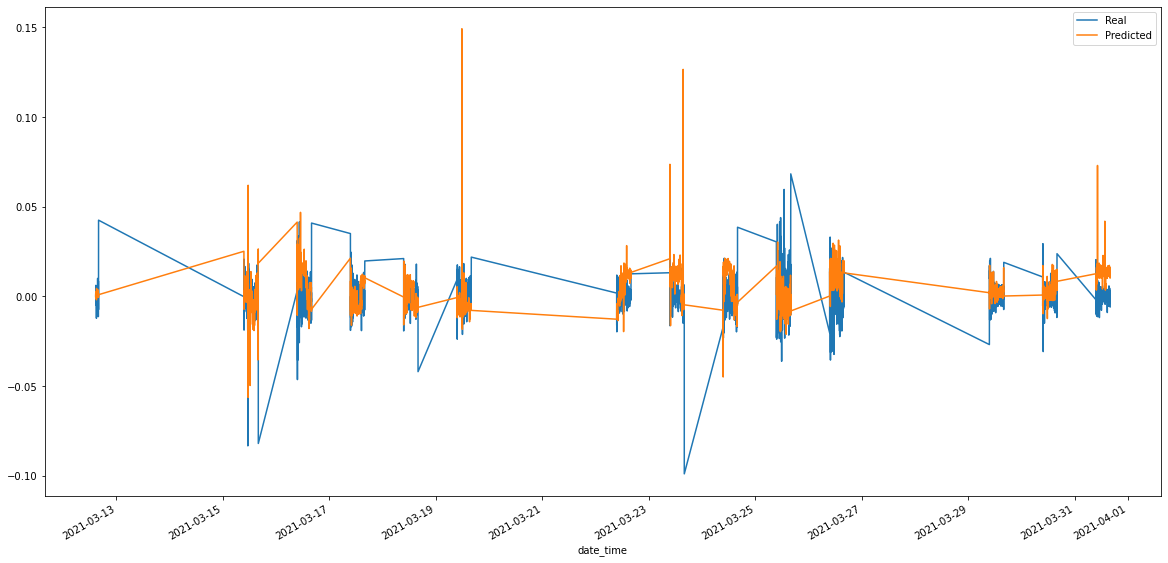

In [22]:
output.plot(figsize = (20,10))

In [23]:
model.feature_importances_ * 100

array([22.47218375, 11.49840581,  4.10990853,  7.31830694, 17.04442436,
        1.15216148,  0.74324845,  7.44633927, 21.36201027,  6.85301113])

In [24]:
output["right_direction"] = np.where(np.sign(output['Real'])==np.sign(output['Predicted']),1,0)

In [25]:
output

,Real,Predicted,right_direction
date_time,,,
2021-03-12 14:41:00,-0.000182,0.000383,0
2021-03-12 14:42:00,0.001113,0.001362,1
2021-03-12 14:43:00,0.003020,0.000674,1
2021-03-12 14:44:00,0.003996,0.000503,1
2021-03-12 14:45:00,0.003702,0.000151,1
...,...,...,...
2021-03-31 15:54:00,-0.002447,0.013459,0
2021-03-31 15:55:00,-0.000104,0.010154,0
2021-03-31 15:56:00,-0.000047,0.015702,0


In [26]:
output["large_direction_real"] = np.where(np.abs(output['Real']) > 0.01 ,1,0)

In [27]:
output["large_direction_predicted"] = np.where(np.abs(output['Predicted']) > 0.01 ,1,0)

In [28]:
output["large_direction_correct"] = output['large_direction_real'] + output['large_direction_predicted']

In [29]:
output["large_direction_correct"] = np.where(output["large_direction_correct"]==2,1,0)

In [30]:
output.describe()

,Real,Predicted,right_direction,large_direction_real,large_direction_predicted,large_direction_correct
count,5148.000000,5148.000000,5148.000000,5148.000000,5148.000000,5148.000000
mean,-0.000046,0.004074,0.488539,0.103535,0.348679,0.041570
std,0.007213,0.010502,0.499917,0.304686,0.476598,0.199623
min,-0.098989,-0.056361,0.000000,0.000000,0.000000,0.000000
25%,-0.003056,-0.003696,0.000000,0.000000,0.000000,0.000000
50%,-0.000221,0.003173,0.000000,0.000000,0.000000,0.000000
75%,0.002857,0.011983,1.000000,0.000000,1.000000,0.000000
max,0.068279,0.149187,1.000000,1.000000,1.000000,1.000000


In [31]:
output.sum()

Real                           -0.235206
Predicted                      20.975515
right_direction              2515.000000
large_direction_real          533.000000
large_direction_predicted    1795.000000
large_direction_correct       214.000000
dtype: float64

In [32]:
2515/5148

0.48853923853923853